# S&P 500 데이터 분석 및 전처리

이 노트북에서는 S&P 500 과거 데이터를 분석하고 전처리합니다.

## 목표
- 데이터 로드 및 탐색
- 결측치 처리
- 이상치 탐지 및 처리
- 기술적 지표 생성 (특성 엔지니어링)
- 각 단계별 시각화

In [2]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from scipy import stats
import ta  # 기술적 지표 라이브러리

warnings.filterwarnings('ignore')

# 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("✅ 라이브러리 임포트 완료")

✅ 라이브러리 임포트 완료


## 1. 데이터 로드 및 초기 탐색

In [3]:
# 데이터 로드
df_raw = pd.read_csv('../data/raw/sp500_raw.csv', encoding='utf-8-sig')

print(f"원본 데이터 형태: {df_raw.shape}")
print(f"컬럼: {list(df_raw.columns)}")

# 첫 몇 행 확인
print("\n=== 원본 데이터 미리보기 ===")
display(df_raw.head(10))

원본 데이터 형태: (22, 7)
컬럼: ['날짜', '종가', '시가', '고가', '저가', '거래량', '변동 %']

=== 원본 데이터 미리보기 ===


,날짜,종가,시가,고가,저가,거래량,변동 %
0,2025- 08- 12,"6,445.76","6,395.17","6,446.55","6,385.76",NaN,1.13%
1,2025- 08- 11,"6,373.45","6,389.67","6,407.25","6,364.06",NaN,-0.25%
2,2025- 08- 08,"6,389.45","6,355.22","6,395.16","6,355.22",NaN,0.78%
3,2025- 08- 07,"6,340.00","6,374.32","6,389.71","6,310.32",NaN,-0.08%
4,2025- 08- 06,"6,345.06","6,309.30","6,352.83","6,301.11",NaN,0.73%
5,2025- 08- 05,"6,299.19","6,336.63","6,346.00","6,289.37",NaN,-0.49%
6,2025- 08- 04,"6,329.94","6,271.71","6,330.69","6,271.71",NaN,1.47%
7,2025- 08- 01,"6,238.01","6,287.28","6,287.28","6,212.69",NaN,-1.60%
8,2025- 07- 31,"6,339.39","6,427.02","6,427.02","6,327.64",NaN,-0.37%
9,2025- 07- 30,"6,362.90","6,381.23","6,396.54","6,336.38",NaN,-0.12%


In [4]:
# 데이터 타입 확인
print("=== 데이터 타입 ===")
print(df_raw.dtypes)

print("\n=== 각 컬럼의 샘플 값 ===")
for col in df_raw.columns:
    print(f"{col}: {df_raw[col].iloc[0]} (타입: {type(df_raw[col].iloc[0])})")

=== 데이터 타입 ===
날짜       object
종가       object
시가       object
고가       object
저가       object
거래량     float64
변동 %     object
dtype: object

=== 각 컬럼의 샘플 값 ===
날짜: 2025- 08- 12 (타입: <class 'str'>)
종가: 6,445.76 (타입: <class 'str'>)
시가: 6,395.17 (타입: <class 'str'>)
고가: 6,446.55 (타입: <class 'str'>)
저가: 6,385.76 (타입: <class 'str'>)
거래량: nan (타입: <class 'numpy.float64'>)
변동 %: 1.13% (타입: <class 'str'>)


## 2. 데이터 정제 및 전처리

In [5]:
# 데이터 복사 및 정제
df = df_raw.copy()

# 1. 컬럼명 영어로 변경
column_mapping = {
    '날짜': 'Date',
    '종가': 'Close',
    '시가': 'Open', 
    '고가': 'High',
    '저가': 'Low',
    '거래량': 'Volume',
    '변동 %': 'Change_Pct'
}

df = df.rename(columns=column_mapping)
print(f"컬럼명 변경 완료: {list(df.columns)}")

# 2. 날짜 컬럼 처리
# 공백 제거 후 datetime 변환
df['Date'] = df['Date'].str.replace(' ', '').str.replace('-', '-')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
print(f"\n날짜 변환 완료. 범위: {df['Date'].min()} ~ {df['Date'].max()}")

# 3. 수치 컬럼 처리 (쉼표 제거 후 float 변환)
numeric_columns = ['Open', 'High', 'Low', 'Close']

for col in numeric_columns:
    df[col] = df[col].str.replace(',', '').astype(float)

# 4. 변동률 처리
df['Change_Pct'] = df['Change_Pct'].str.replace('%', '').astype(float)

print("\n=== 전처리 후 데이터 타입 ===")
print(df.dtypes)

# 5. 날짜순 정렬 (오래된 날짜부터)
df = df.sort_values('Date').reset_index(drop=True)

print("\n=== 전처리 완료 ===")
display(df.head())

컬럼명 변경 완료: ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change_Pct']

날짜 변환 완료. 범위: 2025-07-14 00:00:00 ~ 2025-08-12 00:00:00

=== 전처리 후 데이터 타입 ===
Date          datetime64[ns]
Close                float64
Open                 float64
High                 float64
Low                  float64
Volume               float64
Change_Pct           float64
dtype: object

=== 전처리 완료 ===


,Date,Close,Open,High,Low,Volume,Change_Pct
0,2025-07-14,6268.56,6255.15,6273.31,6239.22,NaN,0.14
1,2025-07-15,6243.76,6295.29,6302.04,6241.68,NaN,-0.40
2,2025-07-16,6263.70,6254.50,6268.12,6201.59,NaN,0.32
3,2025-07-17,6297.36,6263.40,6304.69,6262.27,NaN,0.54
4,2025-07-18,6296.79,6312.95,6315.61,6285.27,NaN,-0.01


## 3. 결측치 분석 및 처리

In [6]:
# 결측치 확인
missing_info = pd.DataFrame({
    '결측치 개수': df.isnull().sum(),
    '결측치 비율(%)': (df.isnull().sum() / len(df) * 100).round(2)
})

print("=== 결측치 분석 ===")
display(missing_info)

# Volume 컬럼 처리 (빈 문자열을 NaN으로 변환)
df['Volume'] = df['Volume'].replace('', np.nan)

# Volume이 모두 결측치인지 확인
volume_missing = df['Volume'].isnull().sum()
print(f"\nVolume 결측치: {volume_missing}/{len(df)} ({volume_missing/len(df)*100:.1f}%)")

if volume_missing == len(df):
    print("⚠️ Volume 데이터가 모두 누락되어 있습니다. 해당 컬럼을 제거합니다.")
    df = df.drop('Volume', axis=1)
else:
    # Volume 데이터가 일부만 있다면 보간법 사용
    df['Volume'] = df['Volume'].interpolate()

print("\n=== 결측치 처리 후 ===")
print(f"최종 데이터 형태: {df.shape}")
print(f"컬럼: {list(df.columns)}")

=== 결측치 분석 ===


,결측치 개수,결측치 비율(%)
Date,0,0.0
Close,0,0.0
Open,0,0.0
High,0,0.0
Low,0,0.0
Volume,22,100.0
Change_Pct,0,0.0



Volume 결측치: 22/22 (100.0%)
⚠️ Volume 데이터가 모두 누락되어 있습니다. 해당 컬럼을 제거합니다.

=== 결측치 처리 후 ===
최종 데이터 형태: (22, 6)
컬럼: ['Date', 'Close', 'Open', 'High', 'Low', 'Change_Pct']


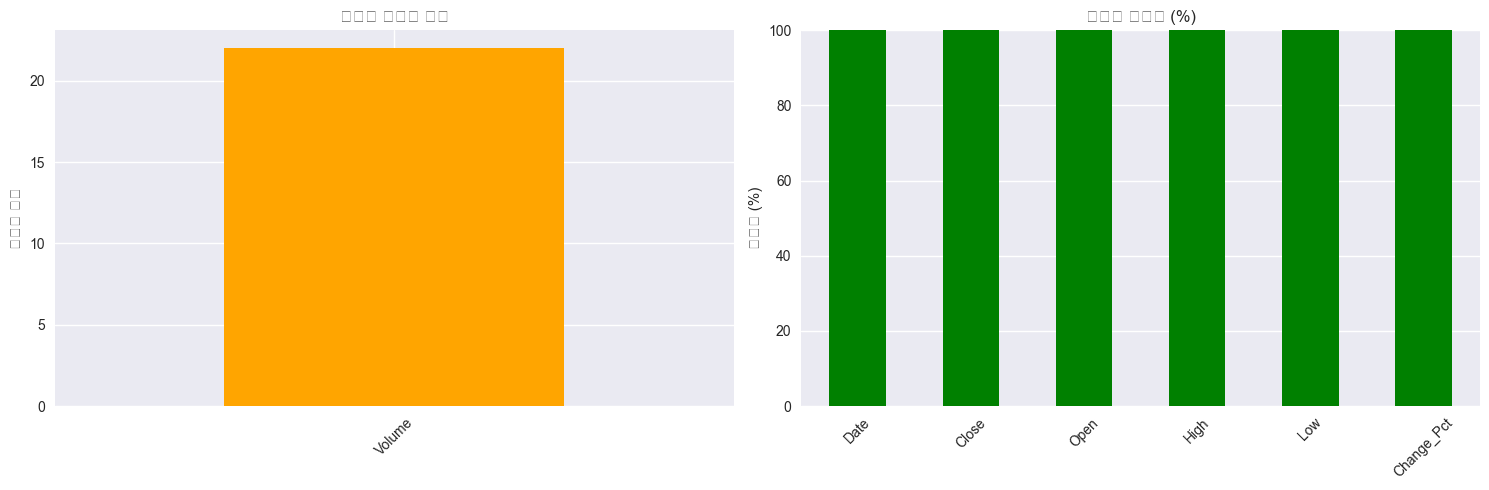

In [7]:
# 결측치 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 전체 결측치 현황
missing_info_filtered = missing_info[missing_info['결측치 개수'] > 0]
if not missing_info_filtered.empty:
    missing_info_filtered['결측치 개수'].plot(kind='bar', ax=axes[0], color='orange')
    axes[0].set_title('컬럼별 결측치 개수')
    axes[0].set_ylabel('결측치 개수')
    axes[0].tick_params(axis='x', rotation=45)
else:
    axes[0].text(0.5, 0.5, '결측치 없음', ha='center', va='center', transform=axes[0].transAxes, fontsize=14)
    axes[0].set_title('결측치 현황')

# 데이터 완성도
completeness = (1 - df.isnull().sum() / len(df)) * 100
completeness.plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('데이터 완성도 (%)')
axes[1].set_ylabel('완성도 (%)')
axes[1].set_ylim(0, 100)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. 기본 통계 및 데이터 분포

In [8]:
# 기본 통계 정보
numeric_cols = df.select_dtypes(include=[np.number]).columns

print("=== 기본 통계 정보 ===")
display(df[numeric_cols].describe().round(2))

# 데이터 기간 정보
date_range = df['Date'].max() - df['Date'].min()
print(f"\n=== 데이터 기간 정보 ===")
print(f"시작일: {df['Date'].min().strftime('%Y-%m-%d')}")
print(f"종료일: {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"총 기간: {date_range.days}일")
print(f"총 거래일: {len(df)}일")

=== 기본 통계 정보 ===


,Close,Open,High,Low,Change_Pct
count,22.00,22.00,22.00,22.00,22.00
mean,6332.73,6335.86,6356.50,6307.10,0.13
std,53.00,53.10,51.87,54.07,0.64
min,6238.01,6254.50,6268.12,6201.59,-1.60
25%,6297.82,6297.65,6315.74,6274.21,-0.22
50%,6339.70,6331.76,6356.74,6307.06,0.06
75%,6368.98,6379.50,6396.36,6359.23,0.50
max,6445.76,6427.02,6446.55,6385.76,1.47



=== 데이터 기간 정보 ===
시작일: 2025-07-14
종료일: 2025-08-12
총 기간: 29일
총 거래일: 22일


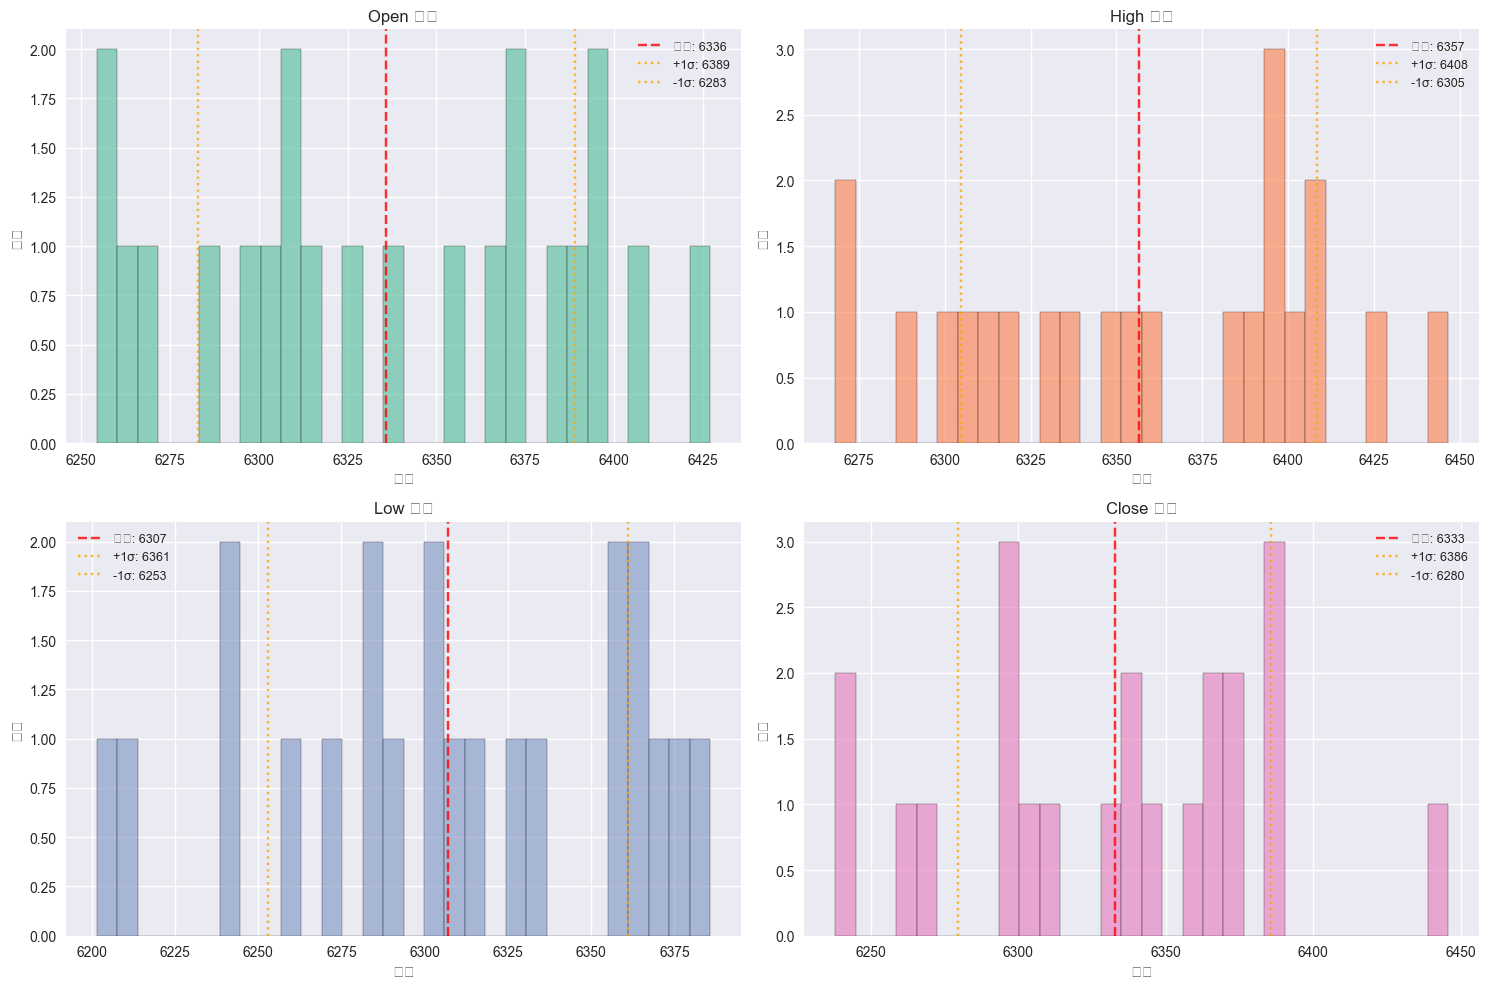

In [9]:
# 가격 데이터 분포 시각화
price_cols = ['Open', 'High', 'Low', 'Close']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(price_cols):
    df[col].hist(bins=30, ax=axes[i], alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[i].set_title(f'{col} 분포')
    axes[i].set_xlabel('가격')
    axes[i].set_ylabel('빈도')
    
    # 통계 정보 추가
    mean_val = df[col].mean()
    std_val = df[col].std()
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'평균: {mean_val:.0f}')
    axes[i].axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.8, label=f'+1σ: {mean_val + std_val:.0f}')
    axes[i].axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.8, label=f'-1σ: {mean_val - std_val:.0f}')
    axes[i].legend(fontsize=9)

plt.tight_layout()
plt.show()

## 5. 이상치 탐지 및 분석

In [10]:
# 일일 수익률 계산
df['Daily_Return'] = df['Close'].pct_change() * 100
df['Price_Range'] = df['High'] - df['Low']
df['Price_Range_Pct'] = (df['Price_Range'] / df['Close']) * 100

# 이상치 탐지 함수 (IQR 방법)
def detect_outliers_iqr(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Z-score 방법
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column].dropna()))
    outliers = data[z_scores > threshold]
    return outliers

# 일일 수익률 이상치 탐지
return_outliers_iqr, lower_bound, upper_bound = detect_outliers_iqr(df, 'Daily_Return')
return_outliers_zscore = detect_outliers_zscore(df, 'Daily_Return')

print(f"=== 일일 수익률 이상치 탐지 ===")
print(f"IQR 방법: {len(return_outliers_iqr)}개 ({len(return_outliers_iqr)/len(df)*100:.1f}%)")
print(f"Z-score 방법: {len(return_outliers_zscore)}개 ({len(return_outliers_zscore)/len(df)*100:.1f}%)")
print(f"IQR 범위: [{lower_bound:.2f}%, {upper_bound:.2f}%]")

if len(return_outliers_iqr) > 0:
    print("\n=== 극단적 수익률 상위 5개 ===")
    extreme_returns = df.nlargest(5, 'Daily_Return')[['Date', 'Close', 'Daily_Return', 'Change_Pct']]
    display(extreme_returns)
    
    print("\n=== 극단적 하락률 상위 5개 ===")
    extreme_drops = df.nsmallest(5, 'Daily_Return')[['Date', 'Close', 'Daily_Return', 'Change_Pct']]
    display(extreme_drops)

ValueError: Item wrong length 21 instead of 22.

In [ ]:
# 이상치 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 일일 수익률 박스플롯
df.boxplot(column='Daily_Return', ax=axes[0,0])
axes[0,0].set_title('일일 수익률 박스플롯')
axes[0,0].set_ylabel('수익률 (%)')

# 2. 일일 수익률 히스토그램
df['Daily_Return'].hist(bins=50, ax=axes[0,1], alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(lower_bound, color='red', linestyle='--', label=f'하한: {lower_bound:.2f}%')
axes[0,1].axvline(upper_bound, color='red', linestyle='--', label=f'상한: {upper_bound:.2f}%')
axes[0,1].set_title('일일 수익률 분포')
axes[0,1].set_xlabel('수익률 (%)')
axes[0,1].set_ylabel('빈도')
axes[0,1].legend()

# 3. 시계열 수익률 (이상치 강조)
axes[1,0].plot(df['Date'], df['Daily_Return'], color='blue', alpha=0.7, linewidth=0.8)
if len(return_outliers_iqr) > 0:
    axes[1,0].scatter(return_outliers_iqr['Date'], return_outliers_iqr['Daily_Return'], 
                     color='red', s=30, alpha=0.8, label=f'이상치 ({len(return_outliers_iqr)}개)')
axes[1,0].set_title('시계열 일일 수익률 (이상치 강조)')
axes[1,0].set_xlabel('날짜')
axes[1,0].set_ylabel('수익률 (%)')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# 4. 가격 범위 이상치
range_outliers, _, _ = detect_outliers_iqr(df, 'Price_Range_Pct')
df.boxplot(column='Price_Range_Pct', ax=axes[1,1])
axes[1,1].set_title(f'일일 가격 범위 박스플롯\n이상치: {len(range_outliers)}개')
axes[1,1].set_ylabel('가격 범위 (%)')

plt.tight_layout()
plt.show()

## 6. 특성 엔지니어링 - 기술적 지표

In [ ]:
# 기술적 지표 계산
# 1. 이동평균
df['SMA_5'] = df['Close'].rolling(window=5).mean()    # 5일 단순이동평균
df['SMA_10'] = df['Close'].rolling(window=10).mean()  # 10일 단순이동평균
df['SMA_20'] = df['Close'].rolling(window=20).mean()  # 20일 단순이동평균

# 2. 지수이동평균
df['EMA_12'] = df['Close'].ewm(span=12).mean()
df['EMA_26'] = df['Close'].ewm(span=26).mean()

# 3. MACD
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

# 4. RSI (Relative Strength Index)
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Close'])

# 5. 볼린저 밴드
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
bb_std = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

# 6. 변동성 지표
df['Volatility_10'] = df['Daily_Return'].rolling(window=10).std()
df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()

# 7. 거래량 관련 (데이터가 있는 경우)
if 'Volume' in df.columns:
    df['Volume_SMA_10'] = df['Volume'].rolling(window=10).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_10']

# 8. 지지/저항 수준
df['Support'] = df['Low'].rolling(window=20).min()
df['Resistance'] = df['High'].rolling(window=20).max()

# 9. 가격 모멘텀
df['Momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1

# 10. 일별 특성
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

print(f"✅ 기술적 지표 생성 완료")
print(f"총 컬럼 수: {len(df.columns)}")
print(f"새로 생성된 지표: {len(df.columns) - len(column_mapping)}개")

# 새로 생성된 컬럼들
new_columns = [col for col in df.columns if col not in column_mapping.values()]
print(f"\n새로 생성된 지표들:")
for i, col in enumerate(new_columns, 1):
    print(f"{i:2d}. {col}")

In [ ]:
# 기술적 지표 요약 통계
technical_indicators = ['SMA_5', 'SMA_10', 'SMA_20', 'RSI', 'MACD', 'BB_Position', 'Volatility_10']

print("=== 주요 기술적 지표 요약 ===")
display(df[technical_indicators].describe().round(3))

# 현재 시장 상태 분석
latest_data = df.iloc[-1]
print("\n=== 최근 시장 상태 (최신 데이터 기준) ===")
print(f"📅 날짜: {latest_data['Date'].strftime('%Y-%m-%d')}")
print(f"💰 종가: {latest_data['Close']:,.2f}")
print(f"📈 일일 수익률: {latest_data['Daily_Return']:.2f}%")
print(f"📊 RSI: {latest_data['RSI']:.1f} ({'과매수' if latest_data['RSI'] > 70 else '과매도' if latest_data['RSI'] < 30 else '중립'})")
print(f"🎯 볼린저 밴드 위치: {latest_data['BB_Position']:.3f} ({'상단' if latest_data['BB_Position'] > 0.8 else '하단' if latest_data['BB_Position'] < 0.2 else '중간'})")
print(f"⚡ 변동성 (10일): {latest_data['Volatility_10']:.2f}%")

## 7. 기술적 지표 시각화

In [ ]:
# 1. 가격 차트와 이동평균
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 상단: 가격과 이동평균, 볼린저 밴드
axes[0].plot(df['Date'], df['Close'], label='종가', color='black', linewidth=1.5)
axes[0].plot(df['Date'], df['SMA_5'], label='SMA(5)', color='red', alpha=0.8)
axes[0].plot(df['Date'], df['SMA_10'], label='SMA(10)', color='blue', alpha=0.8)
axes[0].plot(df['Date'], df['SMA_20'], label='SMA(20)', color='green', alpha=0.8)
axes[0].fill_between(df['Date'], df['BB_Upper'], df['BB_Lower'], alpha=0.2, color='gray', label='볼린저 밴드')
axes[0].set_title('S&P 500 가격 차트와 기술적 지표', fontsize=14, fontweight='bold')
axes[0].set_ylabel('가격')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 중간: RSI
axes[1].plot(df['Date'], df['RSI'], color='purple', linewidth=1.5)
axes[1].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='과매수 (70)')
axes[1].axhline(y=30, color='green', linestyle='--', alpha=0.7, label='과매도 (30)')
axes[1].axhline(y=50, color='black', linestyle='-', alpha=0.3)
axes[1].fill_between(df['Date'], 70, 100, alpha=0.2, color='red')
axes[1].fill_between(df['Date'], 0, 30, alpha=0.2, color='green')
axes[1].set_title('RSI (Relative Strength Index)', fontweight='bold')
axes[1].set_ylabel('RSI')
axes[1].set_ylim(0, 100)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 하단: MACD
axes[2].plot(df['Date'], df['MACD'], label='MACD', color='blue')
axes[2].plot(df['Date'], df['MACD_Signal'], label='Signal', color='red')
# MACD 히스토그램
colors = ['green' if x >= 0 else 'red' for x in df['MACD_Histogram']]
axes[2].bar(df['Date'], df['MACD_Histogram'], color=colors, alpha=0.3, width=0.8)
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[2].set_title('MACD', fontweight='bold')
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('날짜')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 2. 변동성과 모멘텀 분석
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 변동성 차트
axes[0,0].plot(df['Date'], df['Volatility_10'], color='orange', label='10일 변동성')
axes[0,0].plot(df['Date'], df['Volatility_20'], color='red', label='20일 변동성')
axes[0,0].set_title('변동성 지표')
axes[0,0].set_ylabel('변동성 (%)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 모멘텀 차트
axes[0,1].plot(df['Date'], df['Momentum_5'] * 100, color='blue', label='5일 모멘텀')
axes[0,1].plot(df['Date'], df['Momentum_10'] * 100, color='green', label='10일 모멘텀')
axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0,1].set_title('가격 모멘텀')
axes[0,1].set_ylabel('모멘텀 (%)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 볼린저 밴드 위치
axes[1,0].plot(df['Date'], df['BB_Position'], color='purple')
axes[1,0].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='상단')
axes[1,0].axhline(y=0, color='green', linestyle='--', alpha=0.7, label='하단')
axes[1,0].axhline(y=0.5, color='black', linestyle='-', alpha=0.3, label='중앙')
axes[1,0].fill_between(df['Date'], 0.8, 1.2, alpha=0.2, color='red')
axes[1,0].fill_between(df['Date'], -0.2, 0.2, alpha=0.2, color='green')
axes[1,0].set_title('볼린저 밴드 위치')
axes[1,0].set_ylabel('상대적 위치')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 일일 수익률 분포
df['Daily_Return'].hist(bins=30, ax=axes[1,1], alpha=0.7, color='lightblue', edgecolor='black')
axes[1,1].axvline(df['Daily_Return'].mean(), color='red', linestyle='--', label=f'평균: {df["Daily_Return"].mean():.2f}%')
axes[1,1].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[1,1].set_title('일일 수익률 분포')
axes[1,1].set_xlabel('수익률 (%)')
axes[1,1].set_ylabel('빈도')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 인터랙티브 차트 (Plotly)

In [ ]:
# Plotly 캔들스틱 차트
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=('가격 차트', 'RSI', 'MACD'),
    row_heights=[0.6, 0.2, 0.2]
)

# 캔들스틱 차트
fig.add_trace(
    go.Candlestick(
        x=df['Date'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='S&P 500'
    ),
    row=1, col=1
)

# 이동평균선 추가
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['SMA_20'], name='SMA(20)', line=dict(color='blue', width=1)),
    row=1, col=1
)

# 볼린저 밴드
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['BB_Upper'], name='BB Upper', line=dict(color='gray', width=1, dash='dash')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['BB_Lower'], name='BB Lower', line=dict(color='gray', width=1, dash='dash')),
    row=1, col=1
)

# RSI
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['RSI'], name='RSI', line=dict(color='purple')),
    row=2, col=1
)
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

# MACD
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['MACD'], name='MACD', line=dict(color='blue')),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['MACD_Signal'], name='Signal', line=dict(color='red')),
    row=3, col=1
)

# 레이아웃 설정
fig.update_layout(
    title='S&P 500 종합 기술적 분석',
    height=800,
    showlegend=True,
    xaxis_rangeslider_visible=False
)

fig.show()

## 9. 상관관계 분석

In [ ]:
# 주요 지표들 간의 상관관계
correlation_columns = [
    'Close', 'Daily_Return', 'RSI', 'MACD', 'BB_Position', 
    'Volatility_10', 'Momentum_5', 'Price_Range_Pct'
]

correlation_matrix = df[correlation_columns].corr()

# 상관관계 히트맵
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix, 
    mask=mask,
    annot=True, 
    cmap='RdBu_r', 
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={"shrink": .8}
)
plt.title('기술적 지표 간 상관관계', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 높은 상관관계 쌍 찾기
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:  # 0.5 이상의 상관관계
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_value
            ))

if high_corr_pairs:
    print("\n=== 높은 상관관계 (|r| > 0.5) ===")
    for var1, var2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        direction = "양의" if corr > 0 else "음의"
        print(f"{var1} ↔ {var2}: {corr:.3f} ({direction} 상관관계)")

## 10. 최종 데이터 저장

In [ ]:
# 최종 처리된 데이터 저장
output_path = '../data/processed/sp500_processed.csv'
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"✅ 처리된 데이터 저장 완료: {output_path}")
print(f"📊 최종 데이터 형태: {df.shape}")
print(f"📅 데이터 기간: {df['Date'].min().strftime('%Y-%m-%d')} ~ {df['Date'].max().strftime('%Y-%m-%d')}")

# 컬럼 정보 요약
column_types = {
    '날짜': ['Date'],
    '기본 가격': ['Open', 'High', 'Low', 'Close'],
    '수익률': ['Daily_Return', 'Change_Pct'],
    '이동평균': ['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26'],
    '기술적지표': ['RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram'],
    '볼린저밴드': ['BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width', 'BB_Position'],
    '변동성': ['Volatility_10', 'Volatility_20', 'Price_Range', 'Price_Range_Pct'],
    '모멘텀': ['Momentum_5', 'Momentum_10'],
    '지지저항': ['Support', 'Resistance'],
    '시간특성': ['Day_of_Week', 'Month', 'Quarter']
}

print("\n=== 컬럼 분류 ===")
for category, columns in column_types.items():
    existing_cols = [col for col in columns if col in df.columns]
    if existing_cols:
        print(f"{category}: {len(existing_cols)}개 - {', '.join(existing_cols)}")

# 데이터 품질 최종 점검
print("\n=== 데이터 품질 점검 ===")
print(f"✅ 결측치: {df.isnull().sum().sum()}개")
print(f"✅ 중복행: {df.duplicated().sum()}개")
print(f"✅ 데이터 타입: 모든 수치 컬럼이 올바르게 변환됨")
print(f"✅ 날짜 정렬: 시계열 순서 정렬 완료")
print(f"✅ 기술적 지표: {len([col for col in df.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Change_Pct']])}개 생성")

## 11. 분석 요약 및 인사이트

In [ ]:
# 주요 통계 요약
print("=== S&P 500 데이터 분석 요약 ===")
print(f"📅 분석 기간: {(df['Date'].max() - df['Date'].min()).days}일 ({len(df)}거래일)")
print(f"💰 가격 범위: {df['Close'].min():,.0f} ~ {df['Close'].max():,.0f}")
print(f"📈 평균 일일 수익률: {df['Daily_Return'].mean():.3f}% (연환산: {df['Daily_Return'].mean() * 252:.1f}%)")
print(f"⚡ 평균 변동성: {df['Daily_Return'].std():.3f}% (연환산: {df['Daily_Return'].std() * np.sqrt(252):.1f}%)")
print(f"📊 샤프 비율 (무위험이자율 0% 가정): {(df['Daily_Return'].mean() * 252) / (df['Daily_Return'].std() * np.sqrt(252)):.2f}")

# 최대 상승/하락
max_gain = df['Daily_Return'].max()
max_loss = df['Daily_Return'].min()
max_gain_date = df.loc[df['Daily_Return'].idxmax(), 'Date']
max_loss_date = df.loc[df['Daily_Return'].idxmin(), 'Date']

print(f"\n📈 최대 상승: {max_gain:.2f}% ({max_gain_date.strftime('%Y-%m-%d')})")
print(f"📉 최대 하락: {max_loss:.2f}% ({max_loss_date.strftime('%Y-%m-%d')})")

# 기술적 지표 현재 상태
current = df.iloc[-1]
print(f"\n=== 현재 기술적 상태 ({current['Date'].strftime('%Y-%m-%d')}) ===")
print(f"🎯 RSI: {current['RSI']:.1f} - ", end="")
if current['RSI'] > 70:
    print("과매수 구간")
elif current['RSI'] < 30:
    print("과매도 구간")
else:
    print("중립 구간")

print(f"📊 볼린저 밴드: {current['BB_Position']:.3f} - ", end="")
if current['BB_Position'] > 0.8:
    print("상단 근접 (과매수 신호)")
elif current['BB_Position'] < 0.2:
    print("하단 근접 (과매도 신호)")
else:
    print("중간 범위")

print(f"⚡ 현재 변동성: {current['Volatility_10']:.2f}% (10일 기준)")

# 추세 분석
sma_trend = "상승" if current['Close'] > current['SMA_20'] else "하락"
macd_trend = "상승" if current['MACD'] > current['MACD_Signal'] else "하락"

print(f"📈 추세 분석:")
print(f"   - SMA(20) 대비: {sma_trend} (현재가 {current['Close']:.0f} vs SMA {current['SMA_20']:.0f})")
print(f"   - MACD: {macd_trend} (MACD {current['MACD']:.2f} vs Signal {current['MACD_Signal']:.2f})")

print("\n=== 다음 분석 단계 권장사항 ===")
print("1. 🤖 머신러닝 모델을 위한 특성 선택")
print("2. 📊 가격 예측 모델 구축")
print("3. 📈 거래 신호 생성 알고리즘 개발")
print("4. 🔄 백테스팅 시스템 구축")
print("5. 📉 리스크 관리 지표 추가")